**Note:**
1. A mistake made on the scale factor for the form factor $scale=2g^2S(S+1)=2*4*7*(7+2)$ not 7(7+1)
2. RMC scale factor 109.86 vs theoretical 2 * 2**2 * 3.5*(3.5+1)=126 (109.86/126=0.872)
3. The data is on for 2 Gd ioins
4. The calculated powder PC single tetrahedron pattern: per unit spin with a=10.5\AA.
   It should be scaled to compare with the data: $q*10.5/10.4$; $I *109/126* 2* 2**2 * 3.5*(3.5+1)$

5. The fit using 444 supercell shows a clean pattern in the HHL plane!



In [1]:
import numpy as np
import os
import fnmatch
from scipy.signal import savgol_filter
from scipy.interpolate import interp1d
import vtk
from vtk.util.numpy_support import vtk_to_numpy
import matplotlib.pyplot as plt # after importting matplotlib, mayavi can not set api to 2: first run mayavi!!!!
import matplotlib as mpl
from scipy.optimize import curve_fit
from latexify import latexify
latexify()
#mpl.style.use('classic')
%matplotlib widget 
#%matplotlib ipympl

# Change the working directory
#dir_orig = os.getcwd()
#os.chdir('/')

def gdformfact(q):# Gd3+ form factor
    s,j,l,ss = q/(4*np.pi), 7/2., 0, 7/2. ### Take care of the fraction 9/2=4
    fc = (j*(j+1)-ss*(ss+1)+l*(l+1))/(3*j*(j+1)+ss*(ss+1)-l*(l+1))

    j0 = [0.0186,25.3867,0.2895,11.1421,0.7135,3.7520,-0.0217]
    j2 = [0.3347,18.4758,1.2465,6.8767,0.9537,2.3184,0.0217]
    
    fm = (j0[0]*np.exp(-j0[1]*s**2) + j0[2]*np.exp(-j0[3]*s**2)+j0[4]*np.exp(-j0[5]*s**2) + j0[6] 
          + s**2*(j2[0]*np.exp(-j2[1]*s**2)+j2[2]*np.exp(-j2[3]*s**2)+j2[4]*np.exp(-j2[5]*s**2)+j2[6])*fc)
    return fm**2

q = np.linspace(0,5,101,endpoint=True)
r=1*np.pi
r=3.7
r = 10.4*np.sqrt(2)/4
print(r)

3.6769552621700474


In [2]:
import matplotlib.pyplot as plt # after importting matplotlib, mayavi can not set api to 2: first run mayavi!!!!
import matplotlib as mpl

# Reset 'Proposed moves' and 'Accepted moves'

In [30]:
import fileinput
import sys

def replaceAllExps(file,searchExps,replaceExps,nb_cases):
    with open(file, 'r') as f:
        lines = f.readlines()
    counts = np.zeros_like(searchExps,dtype='int')
    for idx0, line in enumerate(lines):
        for idx1, searchExp in enumerate(searchExps):
            if searchExp in line:
                lines[idx0] = replaceExps[idx1]
                counts[idx1] = counts[idx1] + 1
        if np.all(counts==nb_cases):
            break
    # write everything back
    with open(file, 'w') as f:
        f.writelines(lines)
        
searchExps,replaceExps = ['PROPOSED_MOVES', 'ACCEPTED_MOVES'], [' PROPOSED_MOVES 0\n', ' ACCEPTED_MOVES 0\n']

file_folder = r'D:\2_Neutron_scattering\0_SpinVert\gdhfo_d7\35mK/'
file_name = '35mK_spins_*.txt'

file_folder = r'D:\2_Neutron_scattering\0_SpinVert\gdhfo_d7\1K/'
file_name = '1K_spins_*.txt'
#replaceAllExps(os.path.join(file_folder,file_name),searchExps,replaceExps,[1,1])

for file in os.listdir(file_folder):
    if fnmatch.fnmatch(file, file_name):      
        print('corrected',file)
        replaceAllExps(os.path.join(file_folder,file),searchExps,replaceExps,[1,1])

corrected 1K_spins_01.txt
corrected 1K_spins_02.txt
corrected 1K_spins_03.txt
corrected 1K_spins_04.txt
corrected 1K_spins_05.txt
corrected 1K_spins_06.txt
corrected 1K_spins_07.txt
corrected 1K_spins_08.txt
corrected 1K_spins_09.txt
corrected 1K_spins_10.txt
corrected 1K_spins_11.txt
corrected 1K_spins_12.txt
corrected 1K_spins_13.txt
corrected 1K_spins_14.txt
corrected 1K_spins_15.txt
corrected 1K_spins_16.txt
corrected 1K_spins_17.txt
corrected 1K_spins_18.txt
corrected 1K_spins_19.txt
corrected 1K_spins_20.txt
corrected 1K_spins_21.txt
corrected 1K_spins_22.txt
corrected 1K_spins_23.txt
corrected 1K_spins_24.txt
corrected 1K_spins_25.txt
corrected 1K_spins_26.txt
corrected 1K_spins_27.txt
corrected 1K_spins_28.txt
corrected 1K_spins_29.txt
corrected 1K_spins_30.txt
corrected 1K_spins_31.txt
corrected 1K_spins_32.txt
corrected 1K_spins_33.txt
corrected 1K_spins_34.txt
corrected 1K_spins_35.txt
corrected 1K_spins_36.txt
corrected 1K_spins_37.txt
corrected 1K_spins_38.txt
corrected 1K

In [16]:
#This binning with the error calculated in this way is not good if the input data has too few point. 
# For example, if nbins=size(x), error will be 0.
def lin_binning(x,y,nbins): #input: data x,y ; No of points you want nbins  
    #nbins+=1     
    x = x[~np.isnan(x)] # remove nan from the data
    y = y[~np.isnan(y)]
    
    n, _ = np.histogram(x, bins=nbins) # n=len(x)/nbins
    n[np.argwhere(n==0)]=1 #repalce 0 by 1 for dividing later
    meanx= np.histogram(x, bins=nbins, weights=x)[0] / n
    meany= np.histogram(x, bins=nbins, weights=y) [0]/ n
    meany2= np.histogram(x, bins=nbins, weights=y*y)[0] / n
    std_y = np.sqrt(meany2 - meany*meany)/np.sqrt(n)
    
    return np.column_stack((meanx,meany,std_y)) #putput: nbins rows, 3 col
#print(data[:,1].min())
# Subtraction: two patterns and only retrun the common region
def subtract(arr0,arr1,factor=1,cal_e=False): #input: arr0 n-by-3 (data), arr1 (bkg)
    '''
    # Test subtract
    arr1 = np.array([[2,1,0],[3,2,0]])
    arr2 = np.array([[0,1,0],[1,2,0]])
    subtract(arr1,arr2)
    '''
    from scipy.interpolate import interp1d
    
    Min = np.max([arr0[:,0].min(),arr1[:,0].min()])
    Max = np.min([arr0[:,0].max(),arr1[:,0].max()])
    #print(Min,Max)
    if Min>=Max:
        raise RuntimeError('no common ranage for the inputs')
    arr0 = arr0[ (Min<=arr0[:,0]) & (arr0[:,0]<=Max), :]
    arr1 = arr1[ (Min<=arr1[:,0]) & (arr1[:,0]<=Max), :]
    
    if len(arr0)<len(arr1):
        f = interp1d(arr1[:,0],arr1[:,1])
        arr0[:,1] = arr0[:,1] - factor*f(arr0[:,0])
        if cal_e:
            f = interp1d(arr1[:,0],arr1[:,2])
            arr0[:,2] = arr0[:,2] + factor*f(arr0[:,0])
        return arr0
    else:
        f = interp1d(arr0[:,0], arr0[:,1])
        arr1[:,1] = f(arr1[:,0]) - factor*arr1[:,1]
        if cal_e:
            f = interp1d(arr0[:,0],arr0[:,2])
            arr1[:,2] = f(arr1[:,0]) + factor*arr1[:,2]   
        return arr1

# Function to exluded regioins of data according to an axis
def exclude_regs0(array, num_of_regs, boundaries): 
    assert num_of_regs == len(boundaries)
    EXstring = 'np.where( ( ({0:}<array[:,0])&(array[:,0]<{1:}) )'.format(*boundaries[0])
    if num_of_regs ==1:
        EXstring = EXstring + ')'
    else:
        for i in range(1,num_of_regs):
            EXstring += '| ( ({0:}<array[:,0])&(array[:,0]<{1:}) )'.format(*boundaries[i])
        EXstring = EXstring + ')'
    return np.delete(array, eval(EXstring), axis=0)    #np.squeeze(array[eval(EXstring),:])

def exclude_regs1(array, num_of_regs, boundaries): 
    assert num_of_regs == len(boundaries)
    for i in range(0,num_of_regs):
        array = np.delete(array, np.where( (boundaries[i][0]<array[:,0])&(array[:,0]<boundaries[i][1]) ), axis=0)
    return array

def exclude_regs2(dat, reg_list):
    """
    dat: 2d array to slicing rows
    reg_list: regions to be excluced defined by lower and upper bounds    
    """
    masks = np.ones_like(dat[:,0], dtype=bool)
    for i in range(len(reg_list)):
        mask = (reg_list[i][0]< dat[:,0]) & (dat[:,0] < reg_list[i][1])
        masks = masks & (~mask)
    return dat[masks,:]
#exclude_regs(data_q[:,0:2], 3, [[0,0.5],[2.05,2.10],[3,4]])

In [ ]:
plt.figure()
plt.plot(q,-np.sin(q*r)/(q*r),label=r'$-\frac{\sin(Qr)}{Qr}$')
plt.plot(q,-np.sin(q*r)/(q*r)*gdformfact(q),label=r'$-f(Q)\frac{\sin(Qr)}{Qr}$')
plt.plot(q,(1-np.sin(q*r)/(q*r))*gdformfact(q),label=r'$f(Q)(1+\frac{\sin(Qr)}{Qr})$')
plt.axhline(y=0)
plt.legend(loc='best')
plt.show()

# `fname`: Save xy.dat from xye.txt for WinPlot

In [4]:
fpath = r'D:\2_Neutron_Scattering\2_D7_ILL_Gd2Hf2O7_Feb2020\ILLData_201_d7_exp_5-32-883_processed'
fname = '*_SV.txt'# xye file

fnames=[] #index for different files
for file in os.listdir(fpath):
    if fnmatch.fnmatch(file, fname):      
        print(file)
        fnames.append(os.path.join(fpath,file))
print(fnames)

# for fn in fnames:
#     xye = np.genfromtxt(fn)
#     np.savetxt(os.path.join(fn.replace('.txt','.dat')), xye[:,0:2], delimiter=' ')


T1K_SV.txt
T2K_SV.txt
T30K_SV.txt
T35mK_SV.txt
T4K_SV.txt
T8K_SV.txt
['D:\\2_Neutron_Scattering\\2_D7_ILL_Gd2Hf2O7_Feb2020\\ILLData_201_d7_exp_5-32-883_processed\\T1K_SV.txt', 'D:\\2_Neutron_Scattering\\2_D7_ILL_Gd2Hf2O7_Feb2020\\ILLData_201_d7_exp_5-32-883_processed\\T2K_SV.txt', 'D:\\2_Neutron_Scattering\\2_D7_ILL_Gd2Hf2O7_Feb2020\\ILLData_201_d7_exp_5-32-883_processed\\T30K_SV.txt', 'D:\\2_Neutron_Scattering\\2_D7_ILL_Gd2Hf2O7_Feb2020\\ILLData_201_d7_exp_5-32-883_processed\\T35mK_SV.txt', 'D:\\2_Neutron_Scattering\\2_D7_ILL_Gd2Hf2O7_Feb2020\\ILLData_201_d7_exp_5-32-883_processed\\T4K_SV.txt', 'D:\\2_Neutron_Scattering\\2_D7_ILL_Gd2Hf2O7_Feb2020\\ILLData_201_d7_exp_5-32-883_processed\\T8K_SV.txt']


# Fit 30K data (paramagnetic formfactor)

## Fit using curve_fit (not working)

In [ ]:
# Using scipy: why error?

#print(gdformfact(x))

x, y, e = np.hsplit(np.genfromtxt(fnames[2]), 3)
print(x.shape)
#popt, pcov = curve_fit(lambda x,p: p*gdformfact(x), x, y, p0=10,bounds=[[0],[15]])#, sigma=e, absolute_sigma=True)
f = lambda x, *p: p[0]*x + p[1]
popt, pcov = curve_fit(lambda x, aa, bb: (aa*x+bb), x, y, p0=[-1,10])

# plt.figure()
# plt.plot(q,gdformfact(q),label=r'$f(Q)$')
# plt.errorbar(x,y, yerr = e)
# plt.axhline(y=0)
# plt.legend(loc='best')
# plt.show()

## Fit using Lmfit

In [ ]:
# Then we use lmfit
from lmfit import Model,Parameters, Parameter, report_fit

regs = [[0,0.4], [2.95,3.2], [3.4,3.6]]
new_dat = exclude_regs0(np.genfromtxt(fnames[2]), len(regs), regs)
#new_dat = exclude_regs1(np.genfromtxt(fnames[2]), len(regs), regs)
#new_dat = exclude_regs2(np.genfromtxt(fnames[2]),  regs)
x,y,e = np.hsplit(new_dat, 3)

#                            2: ions, 2/3: mag, 0.07: barn, 7*9: g^2 J(J+1)
ff_model = Model(lambda x, p: p * 2 * 2./3*0.07265 * 7*9 * gdformfact(x)) 
params = ff_model.make_params()

params['p'].set(value=1, vary=True, min=0, max=20)

result = ff_model.fit(y, x=x, params = params, weights=1/e)
print(result.fit_report(modelpars=None, show_correl=False))

plt.figure()
plt.plot(x, result.best_fit, 'r', lw=0.5,label=r'$f(Q)$')
print(x.shape, y.shape, e.shape)
plt.errorbar(np.squeeze(x),np.squeeze(y), yerr = np.squeeze(e), fmt='o')
plt.axhline(y=0)
plt.ylim([0,6])
plt.legend(loc='best')
plt.show()

# Plot all data

In [14]:
# Powder average of single tetrahedron scatteirng of PC phase
sffss_q_ff = np.genfromtxt(r'D:\2_Neutron_scattering\2_D7_ILL_Gd2Hf2O7_Feb2020/sffss_q_ff.txt',skip_header=1)
#sffss_uc_q_ff = np.genfromtxt(r'D:\5_Neutron_Scattering\15_D7_ILL_Gd2Hf2O7_Feb2020/sffss_q_ff_uc.txt')
#sffss_uc_q_ff.shape

In [ ]:
109.86/(2 * 2**2 * 3.5*(3.5+1))

D:\2_Neutron_Scattering\2_D7_ILL_Gd2Hf2O7_Feb2020\ILLData_201_d7_exp_5-32-883_processed\T30K_SV.txt
D:\2_Neutron_Scattering\2_D7_ILL_Gd2Hf2O7_Feb2020\ILLData_201_d7_exp_5-32-883_processed\T8K_SV.txt
D:\2_Neutron_Scattering\2_D7_ILL_Gd2Hf2O7_Feb2020\ILLData_201_d7_exp_5-32-883_processed\T4K_SV.txt
D:\2_Neutron_Scattering\2_D7_ILL_Gd2Hf2O7_Feb2020\ILLData_201_d7_exp_5-32-883_processed\T2K_SV.txt
D:\2_Neutron_Scattering\2_D7_ILL_Gd2Hf2O7_Feb2020\ILLData_201_d7_exp_5-32-883_processed\T1K_SV.txt
D:\2_Neutron_Scattering\2_D7_ILL_Gd2Hf2O7_Feb2020\ILLData_201_d7_exp_5-32-883_processed\T35mK_SV.txt


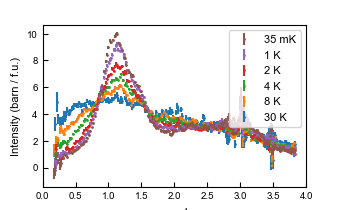

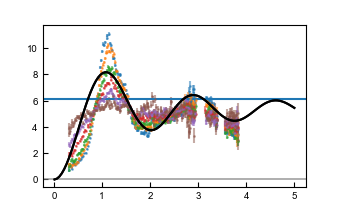

C:\Users\jhxup\AppData\Local\Temp\ipykernel_8144\2369030132.py:64: RuntimeWarning: invalid value encountered in divide
  plt.plot(q,2* 2./3 *0.07265 * 7*(7+2)*(1-np.sin(q*r)/(q*r))*gdformfact(q),label=r'$f(Q)(1-\frac{\sin(Qr)}{Qr})$')
C:\Users\jhxup\AppData\Local\Temp\ipykernel_8144\2369030132.py:68: RuntimeWarning: invalid value encountered in divide
  scf = 1 - np.sin(q*r_1nn)/(q*r_1nn) + 0.3*np.sin(q*r_2nn)/(q*r_2nn) + 0.1*np.sin(q*r_3nn)/(q*r_3nn)


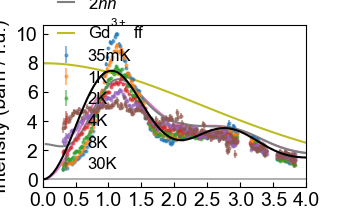

In [17]:
#new_dat = exclude_regs0(np.genfromtxt(fnames[2]), len(regs), regs)
%matplotlib widget
#%matplotlib inline

scale_factor = 0.84
scale_factor = 109.86/(2 * 2**2 * 3.5*(3.5+1))
# Figure without exluding regons
legs = ['1 K', '2 K', '30 K', '35 mK', '4 K', '8 K']
plt.figure()
for i in reversed([3,0,1,4,5,2]):
    #plt.plot(x, result.best_fit, 'r', lw=0.5,label=r'$f(Q)$')
    print(fnames[i])
    new_dat = np.genfromtxt(fnames[i])
    x,y,e = np.hsplit(new_dat, 3)
    plt.errorbar(x.ravel(),y.ravel(), yerr = e.ravel(), fmt='o',ms=1,label=legs[i])
    
plt.xlim([0,4])
#plt.ylim([0,6])
plt.ylabel(r'Intensity (barn / f.u.)')
plt.xlabel(r'$\rm Q\ (\AA^{-1})$')
#plt.axhline(y=0,c='gray',lw=0.2)
#plt.legend(loc='best')
h,l = plt.gca().get_legend_handles_labels()
plt.legend(reversed(h),reversed(l))
#plt.plot(sffss_q_ff[:,4], scale_factor*2*0.07265*7*8* sffss_q_ff[:,5]*sffss_q_ff[:,3],c='black',zorder=30)
plt.show()

# Figure with exluding regons
regs = [[0,0.3], [2.95,3.15], [3.4,3.55]]
fpath = r'D:\2_Neutron_Scattering\2_D7_ILL_Gd2Hf2O7_Feb2020\ILLData_201_d7_exp_5-32-883_processed'
fn = ['1K', '2K', '30K', '35mK', '4K', '8K']

# Plot form factor corrected
plt.figure()
for i in [3,0,1,4,5,2]:
    new_dat = exclude_regs0(np.genfromtxt(fnames[i]), len(regs), regs)
    #print(new_dat.shape)
    #x,y,e = np.hsplit(new_dat, 3)
    #print(x.shape,y.shape,e.shape)
    plt.errorbar(new_dat[:,0], new_dat[:,1]/gdformfact(new_dat[:,0]), yerr = new_dat[:,2]/ gdformfact(new_dat[:,0]),
                 fmt='o',ms=1,label=fn[i],alpha=0.5)
    plt.axhline(y=0,c='gray',lw=0.2)
    #np.savetxt(os.path.join(fpath,fn[i]+'_data.txt'),new_dat)
plt.plot(sffss_q_ff[:,4], scale_factor* 2* 0.07265*7*9*sffss_q_ff[:,3],
         c='black',zorder=30,label='PC tetra.')# /sqrt3**2 for normalized to per uB
plt.plot(sffss_q_ff[:,4], scale_factor* 2* 0.07265*7*9*sffss_q_ff[:,3],
         c='black',zorder=30,label='PC tetra.')# /sqrt3**2 for normalized to per uB
plt.axhline(y=2*2/3* 0.07265*7*9)
plt.show()

# Plot normal
plt.figure()
for i in [3,0,1,4,5,2]:
    new_dat = exclude_regs0(np.genfromtxt(fnames[i]), len(regs), regs)
    #x,y,e = np.hsplit(new_dat, 3)
    plt.errorbar(new_dat[:,0],new_dat[:,1], yerr =new_dat[:,2], fmt='o',ms=2,label=fn[i],alpha=0.5)
    plt.axhline(y=0,c='gray',lw=0.2)
    #np.savetxt(os.path.join(fpath,fn[i]+'_data.txt'),new_dat)
    
plt.plot(sffss_q_ff[:,4]*10.5/10.4, scale_factor * 2*0.07265*7*9* sffss_q_ff[:,5]*sffss_q_ff[:,3],
         c='black',zorder=30,label='PC tetra.')# /sqrt3**2 for nornalized to per uB

#plt.plot(sffss_uc_q_ff[:,4]*1.05, 2* sffss_uc_q_ff[:,5]*sffss_uc_q_ff[:,3],c='black',zorder=30,label='PC u.c.')
plt.plot(q,2* 2./3 *0.07265 * 7*(7+2)*(1-np.sin(q*r)/(q*r))*gdformfact(q),label=r'$f(Q)(1-\frac{\sin(Qr)}{Qr})$')

r = 10.4*np.sqrt(2)/4
r_1nn, r_2nn, r_3nn = r, r*np.sqrt(3), r*2
scf = 1 - np.sin(q*r_1nn)/(q*r_1nn) + 0.3*np.sin(q*r_2nn)/(q*r_2nn) + 0.1*np.sin(q*r_3nn)/(q*r_3nn)
plt.plot(q,2* 2./3 *0.07265 * 7*(7+2)* scf *gdformfact(q),label=r'$2nn$')

# plot Gd magnetic form factor
q_ff = np.linspace(0,5,101,endpoint=True)
ff = scale_factor*2 * 0.07265 * 7*(7+2) * gdformfact(q_ff)
plt.plot(q_ff, ff, label='Gd$^{3+}$ ff')

plt.xlim([0,4])
plt.xticks(color='k', size=14)
plt.yticks(color='k', size=14)

plt.ylabel(r'Intensity (barn / f.u.)',size=14)
plt.xlabel(r"$\rm Q\ (\AA^{-1})$",size=14)
plt.legend(loc='best',frameon=False,fontsize=12, labelspacing=0.4,handlelength=1)
#plt.savefig(r'D:\2_Neutron_Scattering\2_D7_ILL_Gd2Hf2O7_Feb2020\ILLData_201_d7_exp_5-32-883_processed\overlay_PC_ff.pdf',bbox_inches="tight",pad_inches=0.01,verbose=True)
plt.show()

In [ ]:
from PyCrystalField.pcf_lib.form_factors import RE_FormFactor

plt.figure()
plt.plot(sffss_q_ff[:,4], 0.07265*7*(7+2)* sffss_q_ff[:,5]*sffss_q_ff[:,3],c='black',zorder=30,label='PC tetra.')# /sqrt3**2 for nornalized to per uB
q_ff = np.linspace(0,5,101,endpoint=True)
ff = 2./3*0.07265 * 7*(7+2) * gdformfact(q_ff)
plt.plot(q_ff, ff, label='Gd$^{3+}$ ff')

# Compare the formfator from PyCrystalfield
ff = 2./3*0.07265 * 7*(7+2) * RE_FormFactor(q_ff,'Gd3+')
plt.plot(q_ff, ff, label='Gd$^{3+}$ ff')
plt.show()

In [ ]:
np.sqrt(108.4/2), np.sqrt(7*9)

# Func for rmc plot

In [3]:
def rmcPlot(fpath, fname, whichFit, smooth, profix, vmin,vmax):
    '''Plot the data, fit, vkt and the spinCorrel
    fpath is the folder, fname is the name of the data file without '_data.txt';
    whichFit is a nb telling which fitted curve to plot;
    smooth is [int,int] for colormap smoothing;
    profix is the profix of the vtk files'''
    ##### Data and fit#####
    datname = os.path.join(fpath,fname)# data file name without '_dat.txt'
    data = np.genfromtxt(datname+'_data.txt')#data
    # Fitted curves
    fitname= fname+'_fit_0*.txt'# fitted curves
    fnames=[] #index for different files
    for file in os.listdir(fpath):
        if fnmatch.fnmatch(file, fitname):      
            print(file)
            fnames.append(file)
    fitnameXu= fname+'_fit_xu*.txt'# fitted curves
    fnamesXu=[] #index for different files
    for file in os.listdir(fpath):
        if fnmatch.fnmatch(file, fitnameXu):      
            print(file)
            fnamesXu.append(file)

    # Plot data and fit
    fig=plt.figure()
    plt.errorbar(data[:,0],data[:,1],data[:,2], color='black', fmt='o',markersize='3', label='Data')
    
    fit = np.genfromtxt(os.path.join(fpath,fnames[whichFit]), dtype=None, skip_header=1,delimiter=None)
    regs = [[0,0.4], [2.95,3.2], [3.4,3.6]]
    x = fit[:,0]
    y = np.ma.masked_where( ((x>0)&(x<0.4)) | ((x>2.95)&(x<3.2)) | ((x>3.4)&(x<3.6)), fit[:,1]) 
    plt.plot(x,y,'red', label='Fit',zorder=30)  
    #plt.plot(fit[:,0],data[1:,1]-fit[:,1],'red', label='Difference')
    if len(fnamesXu)>whichFit:
        fit = np.genfromtxt(os.path.join(fpath,fnamesXu[whichFit]), dtype=None, skip_header=1,delimiter=None)
        plt.plot(fit[:,0],fit[:,1],'blue', label='Fit',zorder=30)  
    
    plt.xlabel(r"$\rm Q\ (\AA^{-1}$)")
    plt.ylabel('Intensity (a.u.)')
    plt.ylabel('Intensity (barn/f.u.)')
    plt.minorticks_on()
    plt.xticks(color='k')
    plt.yticks(color='k')
    plt.legend()
    print(os.path.join(fpath,datname)+'_fit.png')
    plt.savefig(os.path.join(fpath,datname)+'_fit.pdf', bbox_inches="tight")
    plt.show()
    
    ##### Simulated single crystal [HHL] plane #####
    if os.path.exists(datname+'_sc'+profix+'.vtk'):
        vtkpath = datname+'_sc'+profix+'.vtk' #_sc.vtk'
        print(vtkpath)
        x, y, intensity = loadvtk(vtkpath)        
        pltmap(x, y, intensity,smooth)#,vmin,vmax)
        #plt.title(fname+'\n'+'unpolarized neutron')
        plt.savefig(os.path.join(fpath,datname)+'_single_crystal_simulation.pdf',bbox_inches="tight")
        plt.show()
    if os.path.exists(datname+'_sc_sf'+profix+'.vtk'):
        x, y, intensity = loadvtk(datname+'_sc_sf'+profix+'.vtk')
        pltmap(x,y,intensity,smooth)#,vmin,vmax)
        plt.title(fname+'\n'+'SF polarized neutron')
        plt.show()        
    if os.path.exists(datname+'_sc_snf'+profix+'.vtk'):
        x, y, intensity = loadvtk(vtkpath)
        pltmap(x,y,intensity,smooth)#,vmin,vmax)
        plt.title(fname+'\n'+'SNF polarized neutron')  
        plt.show()
    
    #### Plot the spin correlation function #######
    if os.path.exists(datname+'_scf.txt'):
        scf = np.genfromtxt(datname+'_scf.txt', dtype=None, skip_header=0,delimiter=None)
        fig, ax = plt.subplots(figsize=(5,4))
        rects1 = ax.bar(scf[:,0],scf[:,1], width=1, color='r')
        plt.axhline(0, color='black', lw=2)
        plt.xticks(color='k', size=14)
        plt.yticks(color='k', size=14)    
        plt.ylabel(r'$<{\bf S}(0)\cdot{\bf S}(r)>$',size=14)
        plt.xlabel(r"$\rm Q\ (\AA)$",size=14)
        plt.show()    
#     fig = plt.figure(figsize=(5,4))   
#     plt.plot(scf[:,0],scf[:,1],color='black',linewidth=1)
#     plt.axhline(y=0)
#     plt.minorticks_on()
#     plt.xticks(color='k', size=14)
#     plt.yticks(color='k', size=14)    
#     plt.ylabel(r'$<{\bf S}(0)\cdot{\bf S}(r)>$',size=14)
#     plt.xlabel(r"$\rm Q\ (\AA)$",size=14)
#     plt.show()
    return

def loadvtk(vtkpath):
    reader = vtk.vtkDataSetReader()
    reader.SetFileName(vtkpath)
    reader.ReadAllScalarsOn()
    reader.ReadAllVectorsOn()
    reader.Update()
    data = reader.GetOutput()
    dim = data.GetDimensions()
    
    d = data.GetPointData()
    array=d.GetArray('spin')
    intensity = vtk_to_numpy(array).reshape(dim[:-1],order='F')
    x = np.zeros(data.GetNumberOfPoints())
    y = np.zeros(data.GetNumberOfPoints())

    for i in range(data.GetNumberOfPoints()):
            x[i],y[i],_ = data.GetPoint(i) # coordinates x,y,z becuase z is the same, so discarded
    x = x.reshape(dim[:-1],order='F')# this type of reshape!!!
    y = y.reshape(dim[:-1],order='F')   
    return x, y/0.0707*0.05, intensity

def pltmap(x,y,intensity,smooth,  ax=None):#,vmin,vmax):
    # Smooth the pattern by Apply gaussian filter
    #print intensity,smooth, vmin,vmax
    import scipy as sp
    import scipy.ndimage 
    sigma_y = smooth[0]
    sigma_x = smooth[1]
    sigma = [sigma_y, sigma_x]
    Z = sp.ndimage.filters.gaussian_filter(intensity, sigma, mode='constant')
    
    # only plot Instrument largest Q range
    Qlim = 4.0
    Qmod = np.sqrt(x**2+2*y**2) # why not the one: Qmod = np.sqrt(2*x**2+y**2)
    Zm = np.ma.masked_where(Qmod > Qlim, Z)
    if ax is None:
        fig, ax = plt.subplots(figsize=(5,4))
    #pcol = plt.pcolormesh(y, x, Zm, cmap='RdBu_r',vmin=vmin,vmax=vmax,linewidth=0,rasterized=True)# '_r' is reversed colormap
    pcol = plt.pcolormesh(y, x, Zm, cmap='jet',linewidth=0,rasterized=True)# '_r' is reversed colormap
    
    pcol.set_edgecolor('face') # remove the white lines in the plot
    #plt.title(fname)
    plt.axis([ -Qlim/1.414, Qlim/1.414,-Qlim, Qlim])
    plt.xlabel('(H,H,0)',size=14)
    plt.ylabel('(0,0,L)',size=14)
    plt.minorticks_on()
    plt.xticks(color='k', size=14)
    plt.yticks(color='k', size=14)
    # set colorbar and its properties
    cb = plt.colorbar() # label='Intensity', ticks=range(0,100)
    cb.ax.set_ylabel('Intensity (a.u.)',fontsize=14)
    cb.ax.tick_params(labelsize=12)
    return ax

35mk_fit_01.txt
35mk_fit_02.txt
35mk_fit_03.txt
35mk_fit_04.txt
35mk_fit_05.txt
35mk_fit_06.txt
35mk_fit_07.txt
35mk_fit_08.txt
35mk_fit_09.txt
D:\2_Neutron_scattering\0_SpinVert\gdhfo_d7\35mK/35mk_fit.png


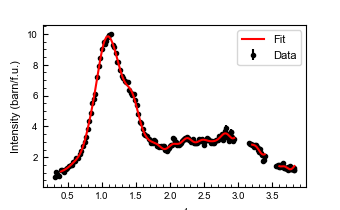

D:\2_Neutron_scattering\0_SpinVert\gdhfo_d7\35mK/35mk_sc.vtk


C:\Users\jhxup\AppData\Local\Temp\ipykernel_26408\2685501619.py:120: DeprecationWarning: Please use `gaussian_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  Z = sp.ndimage.filters.gaussian_filter(intensity, sigma, mode='constant')


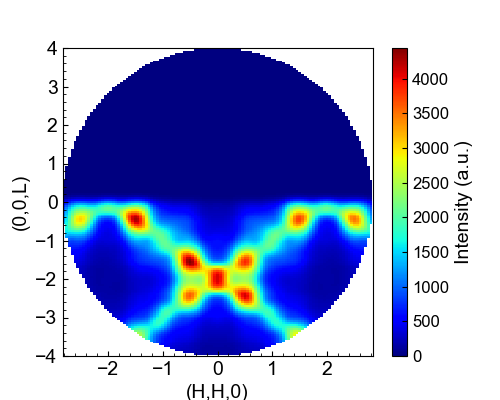

C:\Users\jhxup\AppData\Local\Temp\ipykernel_26408\2685501619.py:120: DeprecationWarning: Please use `gaussian_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  Z = sp.ndimage.filters.gaussian_filter(intensity, sigma, mode='constant')


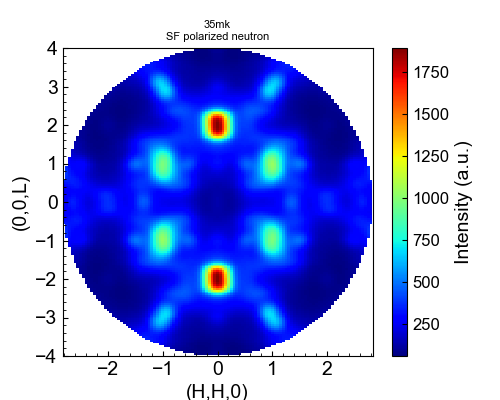

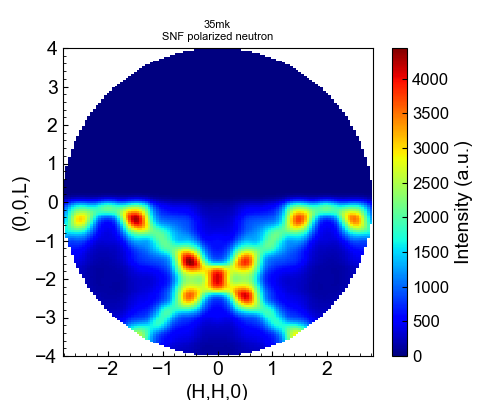

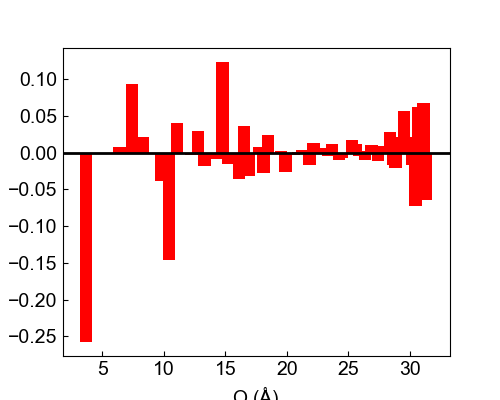

In [6]:
# 35mK
latexify()
fpath=r'D:\2_Neutron_scattering\0_SpinVert\gdhfo_d7\35mK_with_flat_bkg'
#fpath=r'D:\2_Neutron_scattering\0_SpinVert\gdhfo_d7\35mK_easy_plane/'
fpath=r'D:\2_Neutron_scattering\0_SpinVert\gdhfo_d7\35mK/'
#fpath=r'D:\2_Neutron_scattering\0_SpinVert\gdhfo_d7/'
fname = r'35mk'

# fpath=r'D:\2_Neutron_scattering\0_SpinVert\gdhfo_d7\1K/'
# fname = r'1K'

# fpath=r'D:\2_Neutron_scattering\0_SpinVert\gdhfo_d7\2K/'
# fname = r'2K'

# fpath=r'D:\2_Neutron_scattering\0_SpinVert\gdhfo_d7\4K/'
# fname = r'4K'

# fpath=r'D:\2_Neutron_scattering\0_SpinVert\gdhfo_d7\8K/'
# fname = r'8K'

# fpath=r'D:\2_Neutron_scattering\0_SpinVert\gdhfo_d7\30K/'
# fname = r'30K'

whichFit =2
smoothVTK = [2,2]
profix = '' # profix of the vkt file, eg _222box
rmcPlot(fpath,fname,whichFit,smoothVTK,profix,vmin=0,vmax=0)

# Combined plot: RMC and Mean field

## Plot I(Q) curves with RMC and MF fit

D:\2_Neutron_Scattering\2_D7_ILL_Gd2Hf2O7_Feb2020\ILLData_201_d7_exp_5-32-883_processed\T30K_SV.txt
D:\2_Neutron_Scattering\2_D7_ILL_Gd2Hf2O7_Feb2020\ILLData_201_d7_exp_5-32-883_processed\T8K_SV.txt
D:\2_Neutron_Scattering\2_D7_ILL_Gd2Hf2O7_Feb2020\ILLData_201_d7_exp_5-32-883_processed\T4K_SV.txt
D:\2_Neutron_Scattering\2_D7_ILL_Gd2Hf2O7_Feb2020\ILLData_201_d7_exp_5-32-883_processed\T2K_SV.txt
D:\2_Neutron_Scattering\2_D7_ILL_Gd2Hf2O7_Feb2020\ILLData_201_d7_exp_5-32-883_processed\T1K_SV.txt
D:\2_Neutron_Scattering\2_D7_ILL_Gd2Hf2O7_Feb2020\ILLData_201_d7_exp_5-32-883_processed\T35mK_SV.txt


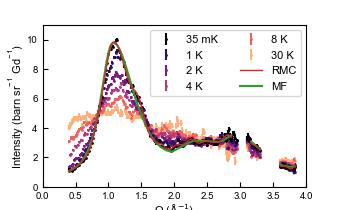

In [5]:
# 1D plot
# First run the sectoin "fname: Save xy.dat from xye..."

# All data
legs = ['1 K', '2 K', '30 K', '35 mK', '4 K', '8 K']
fig = plt.figure()
colors = plt.cm.magma(np.linspace(1,0,7)[1:])
for idx, i in enumerate(reversed([3,0,1,4,5,2])):
    print(fnames[i])
    new_dat = np.genfromtxt(fnames[i])
    x,y,e = new_dat[:,0],new_dat[:,1], new_dat[:,2]
    y = np.ma.masked_where( ((x>0)&(x<0.4)) | ((x>2.95)&(x<3.1)) | ((x>3.3)&(x<3.6)), y) 
    plt.errorbar(x, y, yerr = e, c=colors[idx], fmt='o',ms=1,label=legs[i])

#h,l = plt.gca().get_legend_handles_labels()
#plt.legend(reversed(h),reversed(l))

# RMC data
fpath=r'D:\2_Neutron_scattering\0_SpinVert\gdhfo_d7/35mK'
fname = r'35mk'
datname = os.path.join(fpath, fname) # data file name without '_dat.txt'
#data = np.genfromtxt(datname+'_data.txt')#data
#plt.errorbar(data[:,0],data[:,1],data[:,2],c='black', mew=0.5, fmt='o', mfc='w',markersize='3', label='Data')

fit = np.genfromtxt(datname+'_fit_01.txt', dtype=None, skip_header=1,delimiter=None)
x = fit[:,0]
y = np.ma.masked_where( ((x>0)&(x<0.4)) | ((x>2.87)&(x<3.1)) | ((x>3.3)&(x<3.6)), fit[:,1]) 
#y = fit[:,1]
plt.plot(x,y,'#d62728', label='RMC',zorder=30, lw=1)  

# Mean field
mf_fit = np.genfromtxt(r'D:\2_Neutron_scattering\2_D7_ILL_Gd2Hf2O7_Feb2020\ILLData_201_d7_exp_5-32-883_processed/sqs_fit.txt')
x, y = mf_fit[:,0], mf_fit[:,1]
y = np.ma.masked_where( ((x>0)&(x<0.4)) | ((x>2.87)&(x<3.1)) | ((x>3.3)&(x<3.6)), y) 
ff = gdformfact(x)
plt.plot(x, ff*y,'#2ca02c', label='MF', zorder=10)
plt.xlabel(r'Q $(\mathrm{\mathsf{\AA^{-1}}})$', labelpad=1)
plt.ylabel('Intensity (barn sr$^{-1}$ Gd$^{-1}$)', labelpad=1)

ax = plt.gca()
ax = plt.gca()
ax.set_xlim([0,4.0])
ax.set_ylim([0,11])

plt.legend()
h, l = ax.get_legend_handles_labels()
#ax.legend([h[2],h[0],h[1]], [l[2],l[0],l[1]])
plt.legend([h[7],h[6],h[5],h[4],h[3],h[2],h[0],h[1]], [l[7],l[6],l[5],l[4],l[3],l[2],l[0],l[1],],ncol=2)

#fig.savefig(fpath+'rmc_mf_fit_all_data.pdf', bbox_inches="tight", pad_inches=0.01)
plt.show()

## Just plot all the data

D:\2_Neutron_Scattering\2_D7_ILL_Gd2Hf2O7_Feb2020\ILLData_201_d7_exp_5-32-883_processed\T30K_SV.txt
D:\2_Neutron_Scattering\2_D7_ILL_Gd2Hf2O7_Feb2020\ILLData_201_d7_exp_5-32-883_processed\T8K_SV.txt
D:\2_Neutron_Scattering\2_D7_ILL_Gd2Hf2O7_Feb2020\ILLData_201_d7_exp_5-32-883_processed\T4K_SV.txt
D:\2_Neutron_Scattering\2_D7_ILL_Gd2Hf2O7_Feb2020\ILLData_201_d7_exp_5-32-883_processed\T2K_SV.txt
D:\2_Neutron_Scattering\2_D7_ILL_Gd2Hf2O7_Feb2020\ILLData_201_d7_exp_5-32-883_processed\T1K_SV.txt
D:\2_Neutron_Scattering\2_D7_ILL_Gd2Hf2O7_Feb2020\ILLData_201_d7_exp_5-32-883_processed\T35mK_SV.txt
D:\2_Neutron_Scattering\2_D7_ILL_Gd2Hf2O7_Feb2020\ILLData_201_d7_exp_5-32-883_processed\35mK_data_MF_fit.txt
D:\2_Neutron_Scattering\2_D7_ILL_Gd2Hf2O7_Feb2020\ILLData_201_d7_exp_5-32-883_processed\1K_data_MF_fit.txt
D:\2_Neutron_Scattering\2_D7_ILL_Gd2Hf2O7_Feb2020\ILLData_201_d7_exp_5-32-883_processed\2K_data_MF_fit.txt
D:\2_Neutron_Scattering\2_D7_ILL_Gd2Hf2O7_Feb2020\ILLData_201_d7_exp_5-32-883_pr

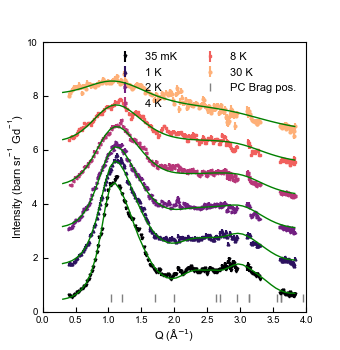

In [42]:
# 1D plot
# First run the sectoin "fname: Save xy.dat from xye..."
fn_fit = ['35mK_data.txt','1K_data.txt','2K_data.txt','4K_data.txt','8K_data.txt', '30K_data.txt']
# All data
legs = ['1 K', '2 K', '30 K', '35 mK', '4 K', '8 K', '30 K']
markers = ['o','s','<', '>', '^','v','+']
latexify(fig_height=3.5)
fig = plt.figure()
colors = plt.cm.magma(np.linspace(1,0,7)[1:])
for idx, i in enumerate(reversed([3,0,1,4,5,2])):
    print(fnames[i])
    new_dat = np.genfromtxt(fnames[i])
    x,y,e = new_dat[:,0],new_dat[:,1]/2+(5-idx)*1.2, new_dat[:,2]/2 # /2: per Gd
    y = np.ma.masked_where( ((x>0)&(x<0.4)) | ((x>2.95)&(x<3.1)) | ((x>3.3)&(x<3.6)), y) 
    plt.errorbar(x, y, yerr = e, c=colors[idx], fmt=markers[idx],ms=2,label=legs[i])

for idx, i in enumerate(fn_fit):
    temp = os.path.join(fpath, fn_fit[idx].replace('.txt', '_MF_fit.txt'))
    print(temp)
    fit = np.genfromtxt(temp)
    plt.plot(fit[:,0], fit[:,1]/2+idx*1.2, c='g',lw=1, zorder=10)
    
##Brag positions
### General
# imax = 4
# for h in np.arange(0,imax):
#     for k in np.arange(h,imax):
#         for l in np.arange(k,imax):
#             if h==k==l==0:
#                 continue
            
#             q = 2*np.pi/10.44 * np.sqrt(h**2+k**2+l**2) # a=10.4 for D7 and 10.5 for D20
        
#             if q>3:
#                 continue
#             ax.axvline(q, 0,0.75, c='grey',alpha=0.5,zorder=0)
#             ax.text(q-0.08, 8, '[{:d},{:d},{:d}]'.format(h,k,l),rotation=90)

### Brag positions for PC phase
hkls = np.array([[1,1,1],[2,0,0],[2,2,0],[3,1,1],[3,3,1],[4,2,0],[4,2,2],[3,3,3],[5,1,1],[5,3,1],[4,4,2],[6,0,0],[5,3,3]])
qs = []
for hkl in hkls:
    h, k, l = hkl
    q = 2*np.pi/10.44 * np.sqrt(h**2+k**2+l**2) # a=10.4 for D7 and 10.5 for D20
    qs.append(q)
    
# for hkl,q in zip(hkls, qs):
#     if q>3.8:
#         continue
#     h, k, l = hkl
#     ax.axvline(q, 0.05,0.1, c='grey',alpha=1,zorder=0)
    #ax.text(q-0.08, 13, '[{:d},{:d},{:d}]'.format(h,k,l),rotation=90)
    
plt.plot(qs, np.full_like(qs, 0.5),'|',c='gray', label='PC Brag pos.')

h,l = plt.gca().get_legend_handles_labels()
plt.legend(reversed(h),reversed(l),frameon=False, ncols=2)
plt.xlabel(r'Q $(\mathrm{\mathsf{\AA^{-1}}})$', labelpad=1)
plt.ylabel('Intensity (barn sr$^{-1}$ Gd$^{-1}$)', labelpad=1)
ax = plt.gca()
ax.set_xlim([0,4.0])
ax.set_ylim([0,10])
fig.savefig(fpath+'nd_all_data_mf_fit.pdf', bbox_inches="tight", pad_inches=0.01)
plt.show()

In [ ]:
plt.close('all')

## Just plot 35mK and RMC & MF

In [5]:
# 1D plot
latexify()
fig = plt.figure()
# RMC data
fpath=r'D:\2_Neutron_scattering\0_SpinVert\gdhfo_d7/35mK/'
fname = r'35mk'
datname = os.path.join(fpath, fname) # data file name without '_dat.txt'
data = np.genfromtxt(datname+'_data.txt')#data
x , y, e = data[:,0],data[:,1]/2,data[:,2]/2
y = np.ma.masked_where( ((x>0)&(x<0.4)) | ((x>2.95)&(x<3.1)) | ((x>3.3)&(x<3.6)), y) 
plt.errorbar(x,y,e,c='black', mew=0.5, fmt='o', mfc='w',ms=2,label='Data (35mK)')

fit = np.genfromtxt(datname+'_fit_01.txt', dtype=None, skip_header=1,delimiter=None)
x = fit[:,0]
y = np.ma.masked_where( ((x>0)&(x<0.4)) | ((x>2.87)&(x<3.1)) | ((x>3.3)&(x<3.6)), fit[:,1]) 
plt.plot(x,y/2,'#d62728', label='RMC',zorder=30, lw=1)  

# Mean field
mf_fit = np.genfromtxt(r'D:\2_Neutron_scattering\2_D7_ILL_Gd2Hf2O7_Feb2020\ILLData_201_d7_exp_5-32-883_processed/sqs_fit.txt')
x, y = mf_fit[:,0], mf_fit[:,1]
y2 = np.ma.masked_where( ((x>0)&(x<0.4)) | ((x>2.87)&(x<3.1)) | ((x>3.3)&(x<3.6)), y) 
ff = gdformfact(x)
plt.plot(x, ff*y2/2,'#2ca02c', label='MF', zorder=10,lw=1)
plt.xlabel(r'Q $(\mathrm{\mathsf{\AA^{-1}}})$', labelpad=1)
plt.ylabel('Intensity (barn sr$^{-1}$ Gd$^{-1}$)', labelpad=1)

ax = plt.gca()

ax.set_xlim([0,4.0])
ax.set_ylim([0,5.5])

plt.plot(sffss_q_ff[:,4]*10.5/10.44, 0.872 * 0.07265*7*9* sffss_q_ff[:,5]*sffss_q_ff[:,3],
         c='gray',lw=1,zorder=30,label='PC tetrahedron')

h, l = ax.get_legend_handles_labels()
ax.legend([h[3],h[0],h[1],h[2]], [l[3],l[0],l[1],l[2]],frameon=False)

#ax.legend()

#fig.savefig(fpath+'rmc_mf_fit.pdf', bbox_inches="tight",pad_inches=0.01)
plt.show()

NameError: name 'sffss_q_ff' is not defined

## RMC and MF 2D HHL plane

C:\Users\jhxup\AppData\Local\Temp\ipykernel_30768\1235896151.py:12: DeprecationWarning: Please use `gaussian_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  Z = sp.ndimage.filters.gaussian_filter((intensity+np.flipud(intensity))/2, [2,2], mode='constant') # Flip up-down because half plane is not 0.


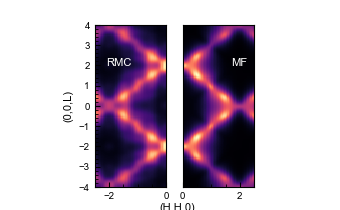

In [6]:
# 2D hhl plane
vtkpath = datname+'_sc.vtk'
vtkpath = r'D:\2_Neutron_scattering\0_SpinVert\gdhfo_d7/35mK/35mK'+'_sc.vtk'
x, y, intensity = loadvtk(vtkpath)      

latexify()
fig, axs = plt.subplots(nrows=1,ncols=2)
plt.subplots_adjust(wspace=-0.5)
import scipy as sp
import scipy.ndimage 

Z = sp.ndimage.filters.gaussian_filter((intensity+np.flipud(intensity))/2, [2,2], mode='constant') # Flip up-down because half plane is not 0.
pcol = axs[0].pcolormesh(y, x, Z, cmap='magma',linewidth=0,rasterized=True)# '_r' is reversed colormap
axs[0].set_aspect(0.707)
axs[0].set_xlim([-2.5,0])
axs[0].set_ylim([-4,4])

x = np.linspace(-3, 3, num=121, endpoint=True)
y = np.linspace(-4, 4, num=161, endpoint=True)
X, Y = np.meshgrid(x, y)
rad = np.sqrt(2*X**2 + Y**2)
Z = np.genfromtxt(r'D:\2_Neutron_scattering\2_D7_ILL_Gd2Hf2O7_Feb2020\ILLData_201_d7_exp_5-32-883_processed/sqs_hhl.txt')
axs[1].pcolor(X, Y, Z.T*gdformfact(rad*2*np.pi/10.5), cmap='magma')
axs[1].set_aspect(0.707)
axs[1].set_xlim([0,2.5])
axs[1].set_ylim([-4,4])

axs[1].set_yticks([])

axs[0].set_xlabel('(H,H,0)')
axs[0].set_ylabel('(0,0,L)')
axs[0].xaxis.set_label_coords(1.15, -.1)
axs[0].minorticks_on()
axs[1].minorticks_on()
    
axs[0].text(-2.1,2,'RMC',c='w')
axs[1].text(1.7,2,'MF',c='w')
#fig.savefig(fpath+'rmc_mf_hhl.pdf', bbox_inches="tight", pad_inches=0.01)
plt.show()

In [108]:
plt.close('all')

C:\Users\jhxup\AppData\Local\Temp\ipykernel_30768\924757876.py:18: DeprecationWarning: Please use `gaussian_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  Z = sp.ndimage.filters.gaussian_filter((intensity+np.flipud(intensity))/2, [2,2], mode='constant') # Flip up-down because half plane is not 0.


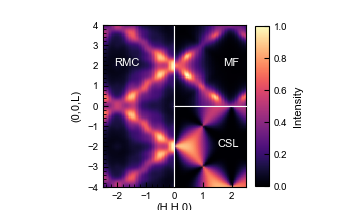

In [7]:
## RMC, MF and classical spin liquid
latexify()
fig = plt.figure()
gs = fig.add_gridspec(2,2)
ax1 = fig.add_subplot(gs[:, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[1, 1])
axs = [ax1,ax2,ax3]
gs.update(wspace=-0.6274, hspace=0.0) # set the spacing between axes. 
#plt.subplots_adjust(wspace=-0.6, hspace=0)

# RMC: 2D hhl plane
vtkpath = datname+'_sc.vtk'
vtkpath = r'D:\2_Neutron_scattering\0_SpinVert\gdhfo_d7/35mK/35mK'+'_sc.vtk'
x, y, intensity = loadvtk(vtkpath)      
import scipy as sp
import scipy.ndimage 
Z = sp.ndimage.filters.gaussian_filter((intensity+np.flipud(intensity))/2, [2,2], mode='constant') # Flip up-down because half plane is not 0.
pcol = axs[0].pcolormesh(y, x, Z/np.max(Z),vmin=0, vmax=1, cmap='magma',linewidth=0,rasterized=True)# '_r' is reversed colormap
pcol.set_edgecolor('face') # remove the white lines in the plot

# from mpl_toolkits.axes_grid1 import make_axes_locatable
# divider = make_axes_locatable(axs[0])
# cax = divider.append_axes('left', size='5%', pad=0)
# fig.colorbar(pcol, cax=cax, orientation='vertical')

#cax = fig.add_axes([1.05, 0, 0.5,1.0])
cax = fig.add_axes([0.75, 0.115, 0.04, 0.76])
fig.colorbar(pcol, cax=cax, orientation='vertical',label='Intensity')

# Mean field
x = np.linspace(-3, 3, num=121, endpoint=True)
y = np.linspace(-4, 4, num=161, endpoint=True)
X, Y = np.meshgrid(x, y)
rad = np.sqrt(2*X**2 + Y**2)
#Z = np.genfromtxt(r'D:\2_Neutron_scattering\2_D7_ILL_Gd2Hf2O7_Feb2020\ILLData_201_d7_exp_5-32-883_processed/sqs_hhl.txt')
Z = np.genfromtxt(r'C:\Users\jhxup\0_MyIpython\Reverse_MC_result_analysis\Gd2Hf2O7\MeanField_RWTH_HPC/sqs_hhl.txt')

axs[1].pcolor(X-0.04, Y, Z.T*gdformfact(rad*2*np.pi/10.5), cmap='magma')
pcol.set_edgecolor('face') # remove the white lines in the plot


# Theory
nQx, nQy = 101,101
x = np.linspace(-3,3,nQx,endpoint=True)
y = np.linspace(-4,4,nQy,endpoint=True)
X, Y = np.meshgrid(x, y)
Z = np.genfromtxt(r'D:\2_Neutron_scattering\0_SpinVert/magStr_pyrohlore_AFM.txt')
Qmod = np.sqrt(2*X**2+Y**2) * 2*np.pi/10.44

pcol = axs[2].pcolormesh(x,y,gdformfact(Qmod)*Z,vmin=0,vmax=8,
                      cmap='magma',linewidth=0,rasterized=True,shading='gouraud')
pcol.set_edgecolor('face') # remove the white lines in the plot

axs[0].set_aspect(0.707)
axs[0].set_xlim([-2.5,0])
axs[0].set_ylim([-4,4])
axs[1].set_aspect(0.707)
axs[1].set_xlim([0,2.5])
axs[1].set_ylim([0,4])
axs[2].set_aspect(0.707)
axs[2].set_xlim([0,2.5])
axs[2].set_ylim([0,-4])

axs[0].set_xlabel('(H,H,0)')
axs[0].set_ylabel('(0,0,L)')
axs[0].xaxis.set_label_coords(1., -.1)
axs[0].minorticks_on()
axs[1].minorticks_on()

axs[1].set_yticks([])
axs[1].set_xticks([])
axs[2].set_yticks([]) 
axs[0].set_xticks([-2,-1,0])
axs[2].set_xticks([1,2])
    
# axs[0].spines['right'].set_visible(False)
# axs[1].spines['left'].set_visible(False)
# axs[2].spines['left'].set_visible(False)

axs[0].spines['right'].set_color('white')
axs[1].spines['left'].set_color('white')
axs[2].spines['left'].set_color('white')

axs[1].spines['bottom'].set_color('white')
axs[2].spines['top'].set_color('white')

axs[0].text(-2.1,2,'RMC',c='w')
axs[1].text(1.7,2,'MF',c='w')
axs[2].text(1.5,-2,'CSL',c='w')
fig.savefig(fpath+'rmc_mf_csl_hhl_1.pdf', bbox_inches="tight", pad_inches=0.01)
plt.show()

In [55]:
fig.savefig('D://Downloads/test.pdf',bbox_inches="tight", pad_inches=0.01)

In [8]:
print(fpath)

D:\2_Neutron_scattering\0_SpinVert\gdhfo_d7/35mK/


In [138]:
plt.close('all')
3.566/3.59, 10.40/10.44

(0.9933147632311977, 0.996168582375479)

## Spin correlation function

[]
[[ 3.67700000e+00 -2.48279709e-01  6.45023252e-04]
 [ 7.35390000e+00  9.92727610e-02  6.27421176e-04]
 [ 1.10309000e+01  3.28878822e-02  4.58651797e-04]
 [ 1.47078000e+01  1.17143588e-01  6.57893827e-04]
 [ 1.83848000e+01  1.95761645e-02  2.69068907e-04]
 [ 2.20617000e+01  1.70376201e-02  3.23038086e-04]
 [ 2.57387000e+01 -3.01248265e-03  2.82131375e-04]
 [ 2.94156000e+01  4.70792087e-02  6.63595711e-04]] 
 [[6.36870000e+00 3.79453340e-04 4.78920160e-04]
 [1.27373000e+01 2.28977394e-02 4.55273199e-04]
 [1.91060000e+01 1.83365055e-03 2.58310267e-04]
 [2.54747000e+01 5.09349440e-03 4.74492517e-04]] 
 []


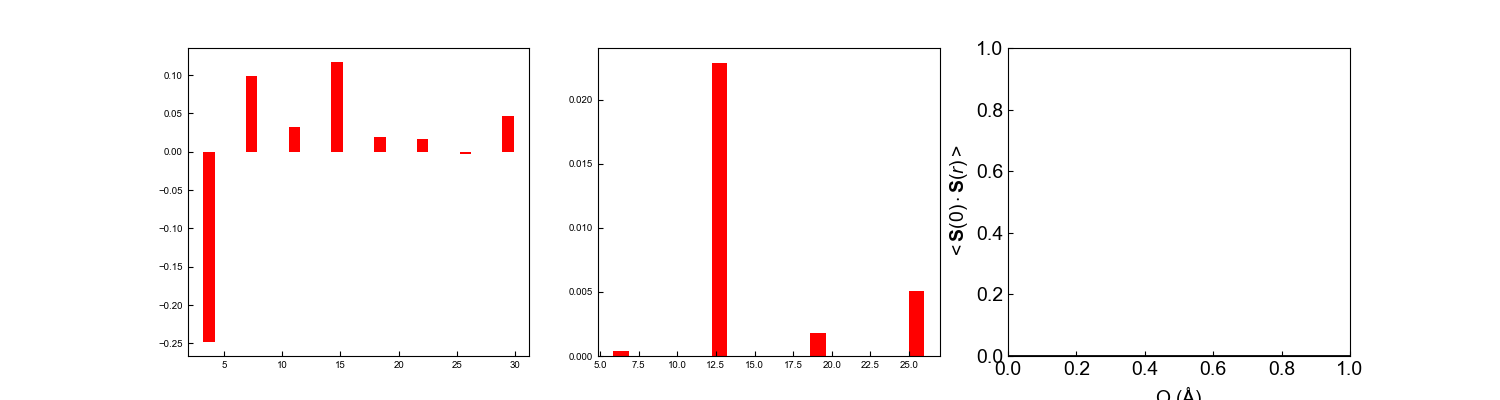

In [3]:
# SCF along different directions
# Not dinstiguished: 2n*r_nn0 and n*r_nn2 (n and m =1,2,3,4,...)!!!

fpath=r'D:\2_Neutron_scattering\0_SpinVert\gdhfo_d7\35mK_with_flat_bkg'
fpath=r'D:\2_Neutron_scattering\0_SpinVert\gdhfo_d7\35mK/'
fname = r'35mk_scf.txt'

# fpath=r'D:\2_Neutron_scattering\0_SpinVert\gdhfo_d7\1K/'
# fname = r'1K_scf.txt'

scf = np.genfromtxt(os.path.join(fpath,fname), dtype=None, skip_header=0,delimiter=None)

def three_nnn_scf(scf):
    nn0, nn1, nn2 = scf[0,0], scf[1,0], scf[2,0]
    nn0s, nn1s, nn2s = [], [], []
    for i in range(0, scf.shape[0]):
        #print(scf[i,0]/nn1,scf[i,0]/nn1 % 1,round(scf[i,0]/nn1 % 1, 1))
        if   np.isclose(scf[i,0]/nn0 % 1, 0, atol=1e-03) | np.isclose(scf[i,0]/nn0 % 1, 1,atol=1e-03):
            nn0s.append(scf[i,:])
        elif np.isclose(scf[i,0]/nn1 % 1, 0, atol=1e-03) | np.isclose(scf[i,0]/nn1 % 1, 1,atol=1e-03):
            nn1s.append(scf[i,:])
        elif np.isclose(scf[i,0]/nn2 % 1, 0, atol=1e-03) | np.isclose(scf[i,0]/nn2 % 1, 1, atol=1e-03):
            nn2s.append(scf[i,:])
    return np.array(nn0s), np.array(nn1s), np.array(nn2s)

nn0s, nn1s, nn2s = three_nnn_scf(scf)
print(nn2s)
print(nn0s,'\n',nn1s,'\n',nn2s)

fig, axs = plt.subplots(figsize=(15,4),nrows=1, ncols=3)
rects1 = axs[0].bar(nn0s[:,0],nn0s[:,1], width=1, color='r')
rects2 = axs[1].bar(nn1s[:,0],nn1s[:,1], width=1, color='r')
#rects3 = axs[2].bar(nn2s[:,0],nn2s[:,1], width=1, color='r')
plt.axhline(0, color='black', lw=2)
plt.xticks(color='k', size=14)
plt.yticks(color='k', size=14)    
plt.ylabel(r'$<{\bf S}(0)\cdot{\bf S}(r)>$',size=14)
plt.xlabel(r"$\rm Q\ (\AA)$",size=14)
plt.show()

In [2]:
5.62/14.08

0.3991477272727273

In [1]:
scf[:,0]

NameError: name 'scf' is not defined

In [6]:
scf[:,0]/10.4*10.18

array([ 3.59921731,  6.2339775 ,  7.19833673,  8.04797519,  9.52250904,
       10.18      , 10.79755404, 11.93712673, 12.46785712, 12.97705288,
       13.93955231, 14.39667346, 14.83979712, 15.68845673, 16.09595038,
       16.49345981, 17.26107096, 17.63224942, 17.99589077, 18.70183462,
       19.04501808, 19.38213269, 20.03933   , 20.36      , 20.67567788,
       21.29303615, 21.59501019, 21.89287308, 22.47685269, 22.76316519,
       23.04595385, 23.60135115, 23.87425346, 24.14402346, 24.67465596,
       24.93581212, 25.1942275 , 25.7032275 , 25.95400788, 26.20234115,
       26.69215577, 27.17316077, 27.64574769, 27.87910462, 28.11040596,
       28.56752712, 28.79334692, 29.01750269, 29.46052846, 29.67949635,
       29.89699596, 30.32719885, 30.54      ])

In [7]:
(16+16+48+8)/10.18**3

0.08341407499830766

In [5]:
fpath = r'D:\2_Neutron_scattering\0_SpinVert\gdhfo_d7\35mK_with_flat_bkg'
fname = r'35mk'
fpath = r'D:\2_Neutron_scattering\0_SpinVert\gdhfo_d7\35mK/'
fname = r'diamond_part'
fnmae = r'35mk'
# fpath = r'D:\2_Neutron_scattering\0_SpinVert\gdzro_ill\gd_ill_60mk-20k_with_paramag/'
# fname = r'diamond_part'

datname = os.path.join(fpath,fname)
fname= datname+'_scf.txt'# fitted curves
data = np.genfromtxt(fname, dtype=None, skip_header=0,delimiter=None)

mask1 = data[:,1] >=0
mask2 = data[:,1] < 0

from ipywidgets import interact,FloatSlider, RadioButtons
x=np.linspace(0.4,35,100)

amplitude_slider1 = FloatSlider(min=3, max=10, step=0.1, value=4.5)
amplitude_slider2 = FloatSlider(min=0, max=10, step=1, value=1)
@interact(r1=amplitude_slider1, r2=amplitude_slider2)
def pltc(r1,r2):
    fig, ax = plt.subplots()#,subplot_kw={'axisbg':'#EEEEEE','axisbelow':True})
    #ax.plot(data[:,0],np.absolute(data[:,1]),color='black',linewidth=1)
    ax.bar(data[mask1,0],np.absolute(data[mask1,1]), width=0.5, label='Positive')
    ax.bar(data[mask2,0],np.absolute(data[mask2,1]), width=0.5, label='Negative')
    ax.plot(x,r2*np.exp(-x/r1),label=r'$\exp({-\frac{r}{%1.1f}})$' %r1 ,c='g')
    #ax.plot(x,r2/x**3,label=r'$38/r^3$',c='black')
    ax.set_ylim(0,0.4)

    plt.minorticks_on()

    #plt.ylabel(r'$|<{\bf S}(0)\cdot{\bf S}(r)>|$',size=14)
    plt.ylabel(r'$<{\bf D}(0)\cdot{\bf D}(r)>$')
    plt.xlabel(r"$r\ \rm(\AA)$")
    
    handles, labels = ax.get_legend_handles_labels()
#     ax.legend([handles[2],handles[3],handles[0],handles[1]], 
#               [labels[2],labels[3],labels[0],labels[1]],frameon=False,framealpha=1,fontsize=14)
    ax.legend([handles[1],handles[2],handles[0]], 
              [labels[1],labels[2],labels[0]],frameon=False,framealpha=1)
    
    plt.show()
    #fig.savefig(fname.replace('.txt','_hard.pdf'), bbox_inches="tight") 
    #fig.savefig(fname.replace('.txt','_soft.pdf'), bbox_inches="tight")  

interactive(children=(FloatSlider(value=4.5, description='r1', max=10.0, min=3.0), FloatSlider(value=1.0, desc…

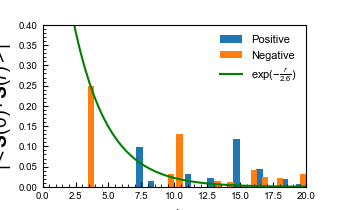

In [6]:
path = r'D:\2_Neutron_scattering\0_SpinVert\gdhfo_d7\35mK/'
fname= '35mk_scf.txt'# fitted curves
data = np.genfromtxt(os.path.join(path,fname), dtype=None, skip_header=0,delimiter=None)

mask1 = data[:,1] >=0
mask2 = data[:,1] < 0

fig, ax = plt.subplots()
ax.bar(data[mask1,0],np.absolute(data[mask1,1]), width=0.5, label='Positive')
ax.bar(data[mask2,0],np.absolute(data[mask2,1]), width=0.5, label='Negative')

x, y = data[:,0], np.abs(data[:,1])
popt, pcov = curve_fit(lambda x,l: np.exp(-x/l), x, y, p0=[3.7])

x = np.linspace(0.4,35,100)
ax.plot(x, np.exp(-x/popt[0]),label=r'$\exp({-\frac{r}{%1.1f}})$' % popt[0] ,c='g')

ax.set_ylim(0,0.4)
ax.set_xlim(0,20)
plt.minorticks_on()
plt.xlabel(r"$r\ \rm(\AA)$")
plt.ylabel(r'$|<{\bf S}(0)\cdot{\bf S}(r)>|$',size=14)

handles, labels = ax.get_legend_handles_labels()
ax.legend([handles[1],handles[2],handles[0]], 
            [labels[1],labels[2],labels[0]],frameon=False,framealpha=1)  

plt.show()  

C:\Users\jhxup\AppData\Local\Temp\ipykernel_14972\4100211235.py:20: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for legend_handle in leg.legendHandles:


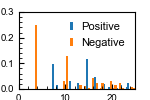

In [32]:
path = r'D:\2_Neutron_scattering\0_SpinVert\gdhfo_d7\35mK/'
fname= '35mk_scf.txt'# fitted curves
data = np.genfromtxt(os.path.join(path,fname), dtype=None, skip_header=0,delimiter=None)

mask1 = data[:,1] >=0
mask2 = data[:,1] < 0

latexify(fig_height=1,fig_width=1.5)
fig, ax = plt.subplots()
ax.bar(data[mask1,0],np.absolute(data[mask1,1]), width=0.5, label='Positive')
ax.bar(data[mask2,0],np.absolute(data[mask2,1]), width=0.5, label='Negative')

ax.set_ylim(0,0.3)
ax.set_xlim(0,25)
plt.minorticks_on()
plt.xlabel(r"$r\ \rm(\AA)$",labelpad=0.)
plt.ylabel(r'$|<{\bf S}(0)\cdot{\bf S}(r)>|$',labelpad=0.1)

leg = ax.legend(frameon=False,framealpha=1,handletextpad=-1)  
for legend_handle in leg.legendHandles:
    legend_handle.set(width=2)
    

fig.savefig(os.path.join(path,fname).replace('.txt','1.pdf'),bbox_inches="tight",pad_inches=0.01)
plt.show()  

# Set PC order and calculate the spin 
fpath = r'D:/2_Neutron_scattering\0_SpinVert\gdhfo_d7/35mK\pc_correlations/'
1. Creat a spin file for PC long-range order with Spinvert format
2. run cmd: spincorel pc
3. Plot scf
4. Check if the PC order is correct by plotting using vPython (in magstr_mayvi_VPython.ipynb)

In [ ]:
tetra = np.array([[0,4,8,13],[1,5,9,12],[2,6,10,15],[3,7,11,14]],dtype='int')

pc_order = np.array([[1,0,-1],[1,0,1],[-1,0,1],[-1,0,-1],  
                     [1,0,-1],[1,0,1],[-1,0,1],[-1,0,-1],  
                     [1,0,-1],[1,0,1],[-1,0,1],[-1,0,-1],  
                     [1,0,-1],[1,0,1],[-1,0,1],[-1,0,-1]])

ind = np.argsort(tetra.reshape([16]))
pc_order = pc_order[ind,:]

In [ ]:
fpath = r'D:/2_Neutron_scattering\0_SpinVert\gdhfo_d7/35mK\pc_correlations/'
fname0 = r'pc_spins_template.txt' # Spinvert *_spin.dat file with a 6x6x6 supercell
fname1 = r'pc_spins_01.txt' # Spinvert *_spin.dat file but with removing line of spins

# with open(os.path.join(fpath,fname0), 'r') as f0:
#     with open(os.path.join(fpath,fname1), 'a') as f1:
#         for line in f0:
#             line=line.rstrip('\n').split()# without giving delimenter, it will treat conseutive space as one
#             if line[0]=="SPIN":
#                 line[5] = pc_order[int(line[1])-1,0]
#                 line[6] = pc_order[int(line[1])-1,1]
#                 line[7] = pc_order[int(line[1])-1,2]
#                 f1.write(" ".join(map(str, line))+"\n")
#                 #f1.write(f"{line}\n")

In [ ]:
dat = np.genfromtxt(os.path.join(fpath,'pc_scf.txt'))
plt.figure()
#plt.errorbar(dat[:,0],dat[:,1],dat[:,2],fmt='o')
plt.scatter(dat[:,0],dat[:,1])
plt.bar(dat[:,0],dat[:,1], width=0.1)
plt.show()

# Test on GGG

In [ ]:
# Test for GGG
%matplotlib inline
fpath = r'D:\9_Program files\SpinVert\GGG'
fname = r'ggg'

whichFit =0
smoothVTK = [0,0]
profix = '' # profix of the vkt file, eg _222box
rmcPlot(fpath,fname,whichFit,smoothVTK,profix,vmin=0,vmax=0)

In [ ]:
print(1.5*2.4/0.07265)
print(1.5*2800/0.07265)
print(0.66667*0.07265*56)
print(0.66667*58*0.07265)
0.06

In [ ]:
# 1K
%matplotlib inline
fpath = r'D:\9_Program files\SpinVert\gdhfo_d7/1K'
fname = r'1K'

whichFit =2
smoothVTK = [0,0]
profix = '' # profix of the vkt file, eg _222box
rmcPlot(fpath,fname,whichFit,smoothVTK,profix,vmin=0,vmax=0)


In [ ]:
# 1K
%matplotlib inline
fpath = r'D:\9_Program files\SpinVert\gdhfo_d7/2k'
fname = r'2k'

whichFit =2
smoothVTK = [0,0]
profix = '' # profix of the vkt file, eg _222box
rmcPlot(fpath,fname,whichFit,smoothVTK,profix,vmin=0,vmax=0)


In [ ]:
# 4K
%matplotlib inline
fpath = r'D:\9_Program files\SpinVert\gdhfo_d7/4k'
fname = r'4k'

whichFit =2
smoothVTK = [0,0]
profix = '' # profix of the vkt file, eg _222box
rmcPlot(fpath,fname,whichFit,smoothVTK,profix,vmin=0,vmax=0)


In [ ]:
# 8K
%matplotlib inline
fpath = r'D:\9_Program files\SpinVert\gdhfo_d7/8k'
fname = r'8k'

whichFit =2
smoothVTK = [0,0]
profix = '' # profix of the vkt file, eg _222box
rmcPlot(fpath,fname,whichFit,smoothVTK,profix,vmin=0,vmax=0)


In [ ]:
# 30K
%matplotlib inline
fpath = r'D:\9_Program files\SpinVert\gdhfo_d7/30k'
fname = r'30k'

whichFit =2
smoothVTK = [0,0]
profix = '' # profix of the vkt file, eg _222box
rmcPlot(fpath,fname,whichFit,smoothVTK,profix,vmin=0,vmax=0)


# Load data separately (no normalization)

In [ ]:
# load
path = 'D:\9_Program files\SpinVert\gdhfo/'
fnames = []
for file in os.listdir(path):
    if fnmatch.fnmatch(file, 'GHO_*.dat'):      
        print(file)
        fnames.append(file)
        
fnames = np.array(fnames)[[0,1,2,3,4,7,8,9,5,6]]

data = []
for idx, f in enumerate(fnames):
    fpath = os.path.join(path,f)
    data.append(read_dmc(fpath))

In [ ]:
# Plot 2theta vs I with smoothing
from scipy.signal import savgol_filter

plt.figure(figsize=[5,4])

for i in np.arange(0,10):
    mask=np.nonzero(data[i][:,1])
    x = data[i][mask,0]    
    y = data[i][mask,1]
    #ysmooth = savgol_filter(y, 11, 3) # window size 51, polynomial order 3   
    plt.scatter(x, y, s=1)
    
#ax=plt.gca()
# ax.set_xlim([10,85])
# ax.set_ylim([1500,5000])

plt.show()

In [ ]:
# 70mK - 20K(2nd dataset)
fpath = r'D:\9_Program files\SpinVert\gdhfo_d7/'
fname = r'35mk'

whichFit =2
smoothVTK = [0,0]
profix = '' # profix of the vkt file, eg _222box
rmcPlot(fpath,fname,whichFit,smoothVTK,profix,vmin=0,vmax=0)

### Load normalized data together

In [ ]:
# Load
fpath = r'D:\9_Program files\SpinVert\gdhfo/'
fname = r'GHO_all_normalized.xyn'
data=np.genfromtxt(os.path.join(fpath,fname),skip_header=2)
print(data.shape)

# Plot 2theta-I
from scipy.signal import savgol_filter

plt.figure()

for i in np.arange(0,11):
    mask=np.nonzero(data[:,2*i])
    x = data[mask,2*i].ravel()    
    y = data[mask,2*i+1].ravel()
    ysmooth = savgol_filter(y, 5, 3) # window size 51, polynomial order 3   
    plt.plot(x, ysmooth)
    #plt.plot(data[:,2*i],data[:,2*i+1])
    
ax=plt.gca()
# ax.set_xlim([10,85])
ax.set_ylim([1,4])

plt.show()

# Convert 2theta to q for all data
#####################
data_q = data.copy()# ！！！！！！！！
#####################
wavelen = 2.45860
for i in np.arange(0,11):
    data_q[:,2*i] = 4*np.pi*np.sin(data_q[:,2*i]/2*np.pi/180.)/wavelen 

In [ ]:
print(data)